#### Metodo de Triangulación en muografia
Eduardo Andres Novoa Carrasco

In [143]:
#Librerias
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt

In [ ]:

# ===================== Aux: carga y proyección =====================

def _load_detector_data(root_path, tree="tree_muonTrk", det_k=0):
    with uproot.open(root_path) as f:
        arr = f[tree].arrays(["mu_sph_X", "mu_sph_Y", "det_idx"], library="ak")
    mask = ak.Array([(v[det_k] if len(v) > det_k else 0) for v in arr["det_idx"]]) == 1
    x = ak.to_numpy(ak.flatten(arr["mu_sph_X"][mask]))
    y = ak.to_numpy(ak.flatten(arr["mu_sph_Y"][mask]))
    return x, y

def _xy_to_angles(XX, YY):
    R = max(abs(XX).max(), abs(YY).max(), 1e-12)
    xN, yN = XX / R, YY / R
    r = np.sqrt(xN**2 + yN**2)
    valid = (r <= 1.0 + 1e-12)
    PHI   = np.where(valid, np.arctan2(yN, xN), np.nan)
    THETA = np.where(valid, np.arcsin(np.clip(r, 0.0, 1.0)), np.nan)
    return PHI, THETA, R

# ===================== Base: sin filtro =====================

def process_detector_simple(sig_file, bkg_file, det_k=0,
                            nbx=40, nby=40, xy_range=(-1.2, 1.2),
                            rotate180=True):
    xmin, xmax = xy_range
    ymin, ymax = xy_range

    #  Datos crudos
    sig_x, sig_y = _load_detector_data(sig_file, det_k=det_k)
    bkg_x, bkg_y = _load_detector_data(bkg_file, det_k=det_k)

    # Histogramas (transpuestos para convención imagen)
    hS, xedges, yedges = np.histogram2d(sig_x, sig_y, bins=[nbx, nby],
                                        range=[[xmin, xmax], [ymin, ymax]])
    hB = np.histogram2d(bkg_x, bkg_y, bins=[nbx, nby],
                        range=[[xmin, xmax], [ymin, ymax]])[0]
    hS, hB = hS.T, hB.T

    # Diferencia normalizada global
    alpha = hS.sum() / (hB.sum() + 1e-12) if hB.sum() > 0 else 1.0
    hD = hS - alpha * hB

    #  Coordenadas y ángulos
    xs = 0.5 * (xedges[:-1] + xedges[1:])
    ys = 0.5 * (yedges[:-1] + yedges[1:])
    XX, YY = np.meshgrid(xs, ys)
    PHI, THETA, R_norm = _xy_to_angles(XX, YY)

    #  Rotación opcional (consistencia visual)
    if rotate180:
        rot2 = lambda a: np.rot90(a, 2)
        hD_rot    = rot2(hD)
        PHI_rot   = rot2(PHI)
        THETA_rot = rot2(THETA)
        XX_rot, YY_rot = rot2(XX), rot2(YY)
    else:
        hD_rot, PHI_rot, THETA_rot = hD, PHI, THETA
        XX_rot, YY_rot = XX, YY

    # Empaquetar
    return {
        "detector": det_k,
        "alpha": alpha,
        "hS": hS, "hB": hB,
        "hD": hD, "hD_rot": hD_rot,
        "XX": XX_rot, "YY": YY_rot,
        "PHI": PHI_rot, "THETA": THETA_rot,
        "R_norm": R_norm,
        "xy_range": (xmin, xmax, ymin, ymax)
    }

def process_all_detectors(sig_file, bkg_file, det_ids=range(6),
                          nbx=40, nby=40, xy_range=(-1.2,1.2),
                          rotate180=True):
    return {
        k: process_detector_simple(sig_file, bkg_file, det_k=k,
                                   nbx=nbx, nby=nby, xy_range=xy_range,
                                   rotate180=rotate180)
        for k in det_ids
    }

# ===================== Plot: 3x2 mapas sin filtro =====================

def plot_detectors_grid(results_dict, key="hD_rot", suptitle="Sin filtro"):
    # results_dict: {det_k: {...}}
    # key: qué campo mostrar (p.ej. 'hD_rot', 'hD_gauss_rot', 'hD_wave_rot')
    fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)
    axes = axes.ravel()
    ks = sorted(results_dict.keys())
    for ax, k in zip(axes, ks):
        r = results_dict[k]
        xmin, xmax, ymin, ymax = r["xy_range"]
        m = r[key]
        vmax = np.nanpercentile(np.abs(m), 98) or 1.0
        vmin = -vmax
        im = ax.imshow(m, extent=[xmin,xmax,ymin,ymax], origin='lower',
                       cmap='RdBu_r', vmin=vmin, vmax=vmax, aspect='auto')
        ax.set_title(f"Detector {k}")
        ax.set_xlabel("X"); ax.set_ylabel("Y")
        fig.colorbar(im, ax=ax, fraction=0.046)
    fig.suptitle(suptitle, fontsize=14)
    plt.show()


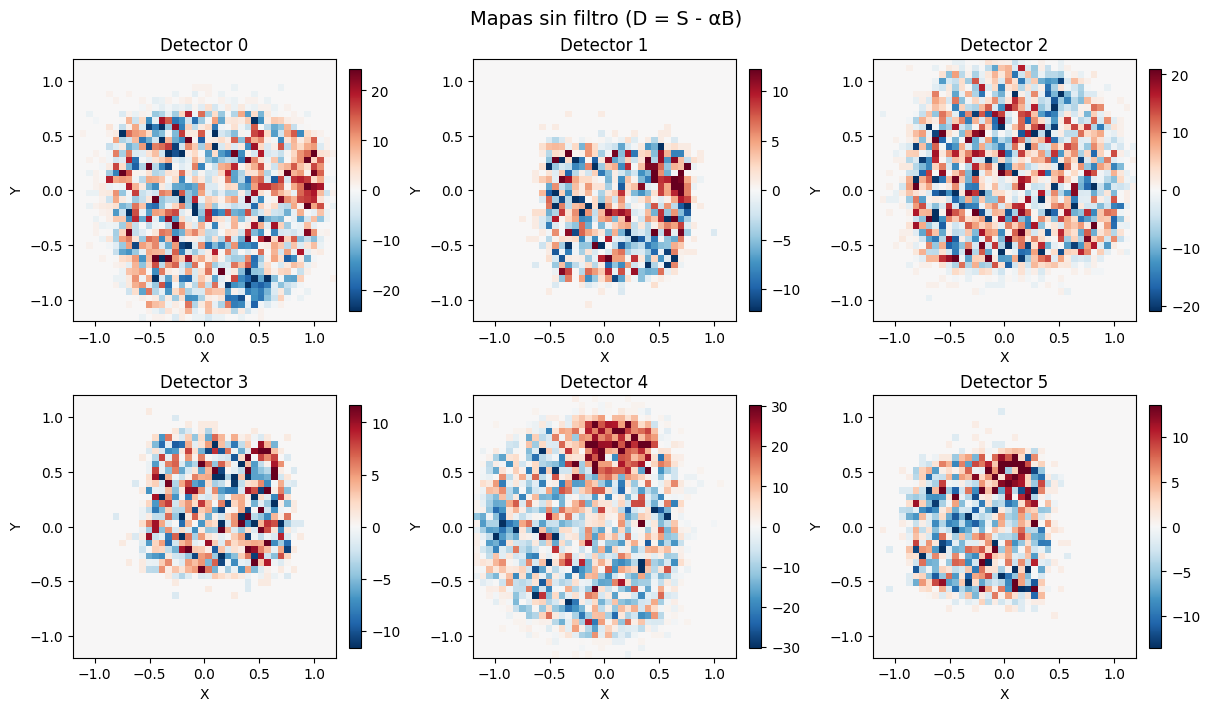

In [145]:
sig_file = "Proc_hist_hostRock_matr_ring.root"
bkg_file = "Proc_hist_hostRock_free_ring.root"

res_raw = process_all_detectors(sig_file, bkg_file, det_ids=range(6),
                                nbx=40, nby=40, xy_range=(-1.2,1.2), rotate180=True)

plot_detectors_grid(res_raw, key="hD_rot", suptitle="Mapas sin filtro (D = S - αB)")


In [ ]:
from scipy.ndimage import gaussian_filter
import pywt  # pip install PyWavelets

# ---------- Gaussiano (filtro espacial) ----------

def apply_gaussian_to_results(results_dict, sigma=1.5):
    out = {}
    for k, r in results_dict.items():
        h = r["hD"]  # filtramos en el espacio no-rotado por coherencia
        h_gauss = gaussian_filter(h, sigma=sigma)
        # rotamos para visualizar igual que el resto
        h_gauss_rot = np.rot90(h_gauss, 2)
        rr = r.copy()
        rr["hD_gauss"] = h_gauss
        rr["hD_gauss_rot"] = h_gauss_rot
        rr["gauss_sigma"] = sigma
        out[k] = rr
    return out

# ---------- Wavelet 2D (suavizado multiescala con umbralado) ----------

def _wavelet_denoise_2d(img, wavelet="db2", level=2, mode="soft"):
    """
    DWT 2D + umbralado suave universal (VisuShrink) estimando sigma
    vía MAD en los coeficientes HH1.
    """
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    cA, *details = coeffs

    # estimar ruido sigma desde detalle de más alta frecuencia
    HH1 = details[-1][2]  # (cH, cV, cD); usamos cD
    sigma = np.median(np.abs(HH1)) / 0.6745 + 1e-12
    # umbral universal
    thr = sigma * np.sqrt(2 * np.log(img.size))

    new_details = []
    for (cH, cV, cD) in details:
        cH = pywt.threshold(cH, value=thr, mode=mode)
        cV = pywt.threshold(cV, value=thr, mode=mode)
        cD = pywt.threshold(cD, value=thr, mode=mode)
        new_details.append((cH, cV, cD))

    den = pywt.waverec2([cA] + new_details, wavelet=wavelet)
    den = den[:img.shape[0], :img.shape[1]]
    return den

def apply_wavelet_to_results(results_dict, wavelet="db2", level=2, mode="soft"):
    out = {}
    for k, r in results_dict.items():
        h = r["hD"]
        h_w = _wavelet_denoise_2d(h, wavelet=wavelet, level=level, mode=mode)
        h_w_rot = np.rot90(h_w, 2)
        rr = r.copy()
        rr["hD_wave"] = h_w
        rr["hD_wave_rot"] = h_w_rot
        rr["wavelet_params"] = {"wavelet": wavelet, "level": level, "mode": mode}
        out[k] = rr
    return out


In [147]:
import numpy as np
from scipy.fft import rfft2, irfft2, fftfreq
import matplotlib.pyplot as plt

# ===================== WIENER (frecuencia) =====================

def _freq_radius(ny, nx):
    fy = fftfreq(ny)[:, None]
    fx = fftfreq(nx)[None, :]
    return np.sqrt(fy**2 + fx**2)

def _wiener_lowpass_freq(h, cutoff_frac=0.2, noise_ring=0.45, detrend=True):
    """
    Filtro Wiener en frecuencia:
    - cutoff_frac: fracción del radio de Nyquist para el gaussiano base
    - noise_ring : umbral radial (>this) para estimar potencia de ruido
    """
    h0 = h.astype(np.float64, copy=False)
    if detrend:
        h0 = h0 - np.mean(h0)

    ny, nx = h0.shape
    # pad a potencias de 2 (suave y rápido)
    py = 1 << (ny - 1).bit_length()
    px = 1 << (nx - 1).bit_length()

    pad_y1, pad_x1 = (py - ny)//2, (px - nx)//2
    pad_y2, pad_x2 = py - ny - pad_y1, px - nx - pad_x1
    h_pad = np.pad(h0, ((pad_y1, pad_y2), (pad_x1, pad_x2)), mode='reflect')

    H = rfft2(h_pad)
    R_full = _freq_radius(py, px)

    # gaussiano radial base
    r_nyq = 0.5 * np.sqrt(2.0)
    sigma = (cutoff_frac * r_nyq) / np.sqrt(2 * np.log(2))
    G_full = np.exp(-(R_full**2) / (2 * sigma**2))
    G = G_full[:, :(px//2 + 1)]

    # potencia de ruido desde anillo alto
    ring = (R_full > noise_ring)[:, :(px//2 + 1)]
    noise_power = np.median(np.abs(H[ring])**2) + 1e-12

    # Wiener
    W = G**2 / (G**2 + noise_power)
    h_filt_pad = irfft2(H * W, s=(py, px))
    h_filt = h_filt_pad[pad_y1:pad_y1+ny, pad_x1:pad_x1+nx]
    return h_filt

def apply_wiener_to_results(results_dict, cutoff_frac=0.2, noise_ring=0.45):
    out = {}
    for k, r in results_dict.items():
        h = r["hD"]  # filtramos en el espacio no-rotado
        h_wi = _wiener_lowpass_freq(h, cutoff_frac=cutoff_frac, noise_ring=noise_ring, detrend=True)
        h_wi_rot = np.rot90(h_wi, 2)
        rr = r.copy()
        rr["hD_wiener"] = h_wi
        rr["hD_wiener_rot"] = h_wi_rot
        rr["wiener_params"] = {"cutoff_frac": cutoff_frac, "noise_ring": noise_ring}
        out[k] = rr
    return out

# ===================== PLOTS 3×2 (reutilizable) =====================

def plot_detectors_grid(results_dict, key="hD_rot", suptitle=""):
    fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)
    axes = axes.ravel()
    ks = sorted(results_dict.keys())
    for ax, k in zip(axes, ks):
        r = results_dict[k]
        xmin, xmax, ymin, ymax = r["xy_range"]
        M = r[key]
        vmax = np.nanpercentile(np.abs(M), 98) or 1.0
        vmin = -vmax
        im = ax.imshow(M, extent=[xmin,xmax,ymin,ymax], origin='lower',
                       cmap='RdBu_r', aspect='auto')
        ax.set_title(f"Detector {k}")
        ax.set_xlabel("X"); ax.set_ylabel("Y")
        fig.colorbar(im, ax=ax, fraction=0.046)
    if suptitle:
        fig.suptitle(suptitle, fontsize=14)
    plt.show()


In [148]:
# diccionarios finales
res_gauss   = apply_gaussian_to_results(res_raw, sigma=1.5)
res_wavelet = apply_wavelet_to_results(res_raw, wavelet="db2", level=3, mode="soft")
res_wiener = apply_wiener_to_results(res_raw, cutoff_frac=0.3, noise_ring=0.45)



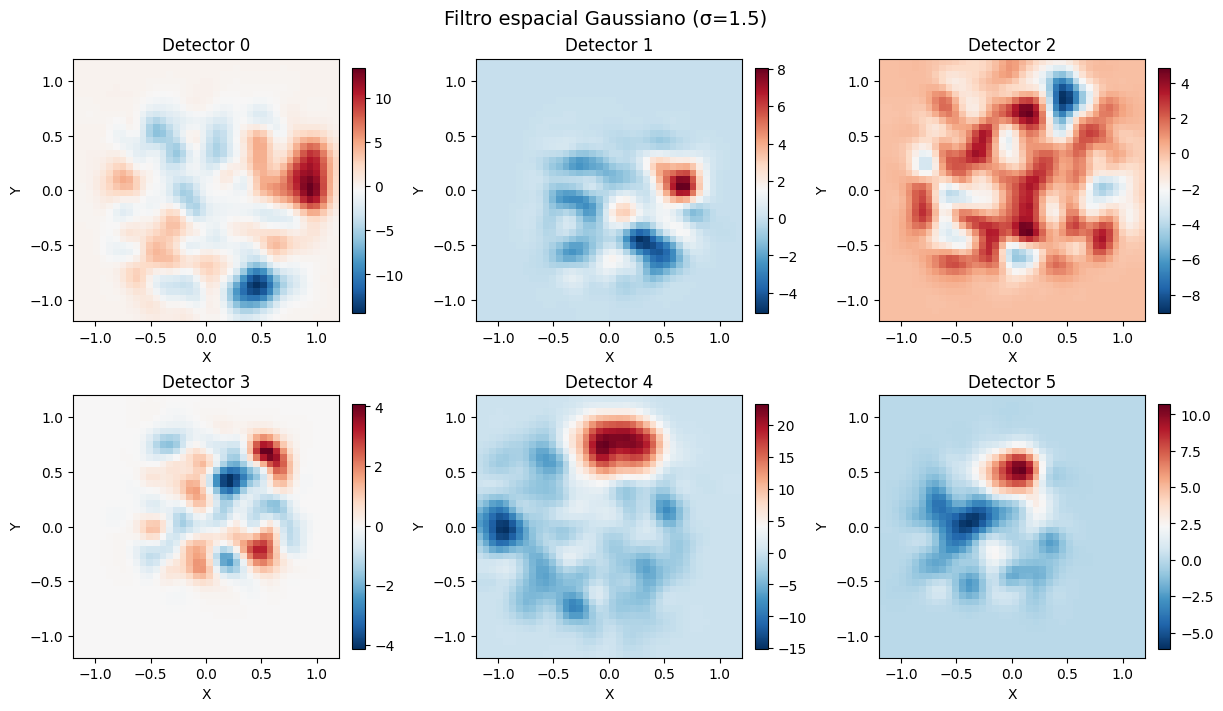

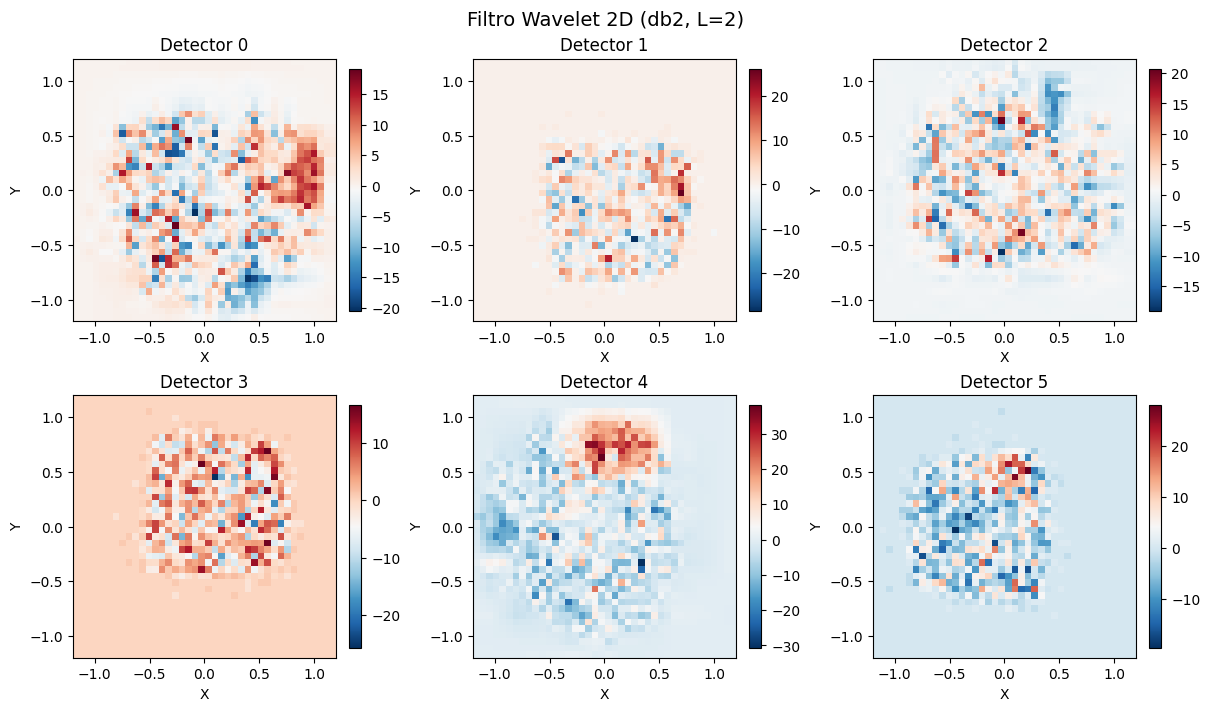

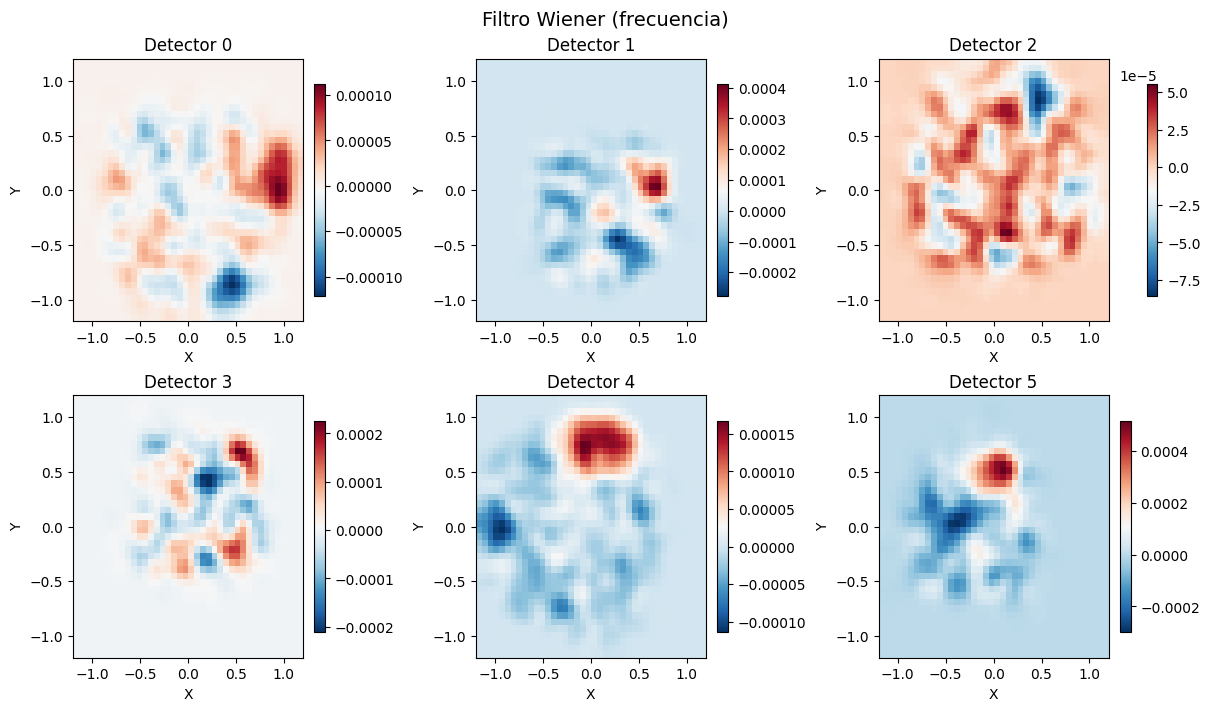

In [149]:
# gráficas 3×2
plot_detectors_grid(res_gauss,  key="hD_gauss_rot",    suptitle="Filtro espacial Gaussiano (σ=1.5)")
plot_detectors_grid(res_wavelet,key="hD_wave_rot",     suptitle="Filtro Wavelet 2D (db2, L=2)")
plot_detectors_grid(res_wiener, key="hD_wiener_rot",   suptitle="Filtro Wiener (frecuencia)")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---  Normalizar por Z-score (por detector, ignorando NaNs) ---
def add_zscore_to_results(results_dict, key_in, key_out):
    out = {}
    for k, r in results_dict.items():
        M = np.array(r[key_in], dtype=float)
        mu = np.nanmean(M)
        sd = np.nanstd(M)
        Mz = (M - mu) / (sd + 1e-12)
        rr = r.copy()
        rr[key_out] = Mz
        out[k] = rr
    return out

# --- 2) Plot 3×2 con escala fija en ±sigma ---
def plot_detectors_grid_fixed_sigma(results_dict, key, sigma_lim=4.0, suptitle=""):
    fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)
    axes = axes.ravel()
    for ax, k in zip(axes, sorted(results_dict.keys())):
        r = results_dict[k]
        xmin, xmax, ymin, ymax = r["xy_range"]
        M = r[key]
        im = ax.imshow(
            M, extent=[xmin, xmax, ymin, ymax], origin='lower',
            cmap='RdBu_r',  aspect='auto'
        )
        ax.set_title(f"Detector {k}")
        ax.set_xlabel("X"); ax.set_ylabel("Y")
        cbar = fig.colorbar(im, ax=ax, fraction=0.046)
        cbar.set_label("σ")
    if suptitle:
        fig.suptitle(suptitle, fontsize=14)
    plt.show()


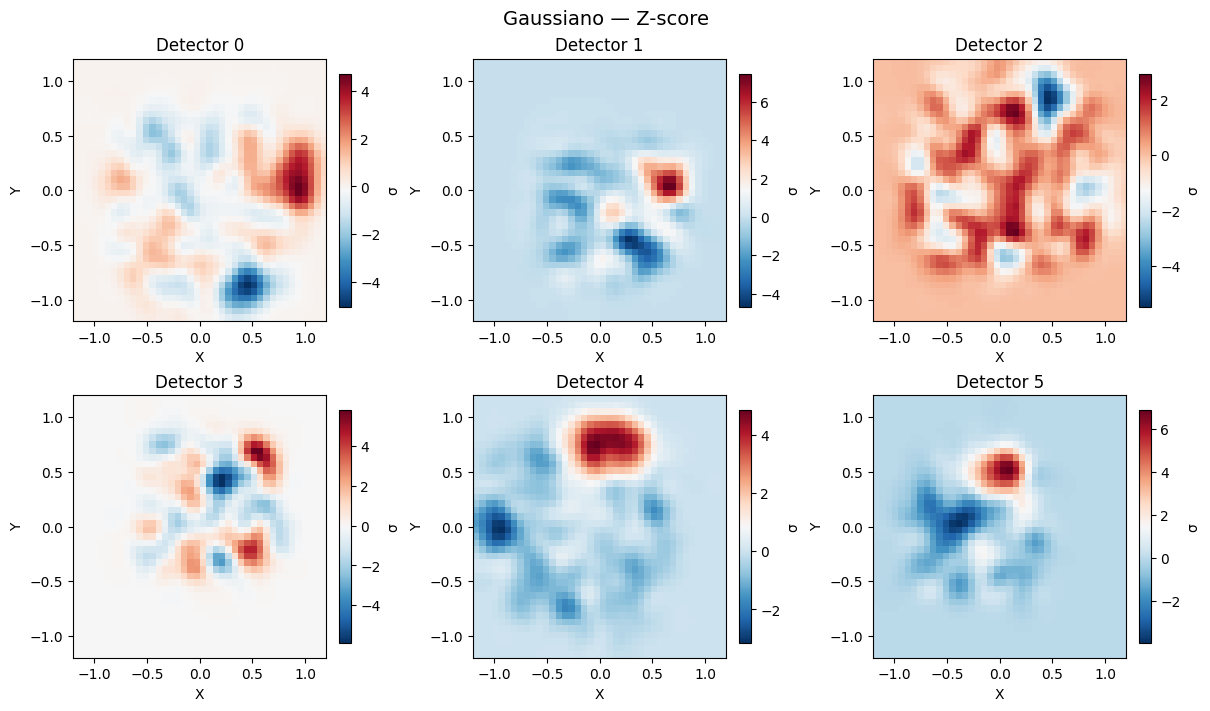

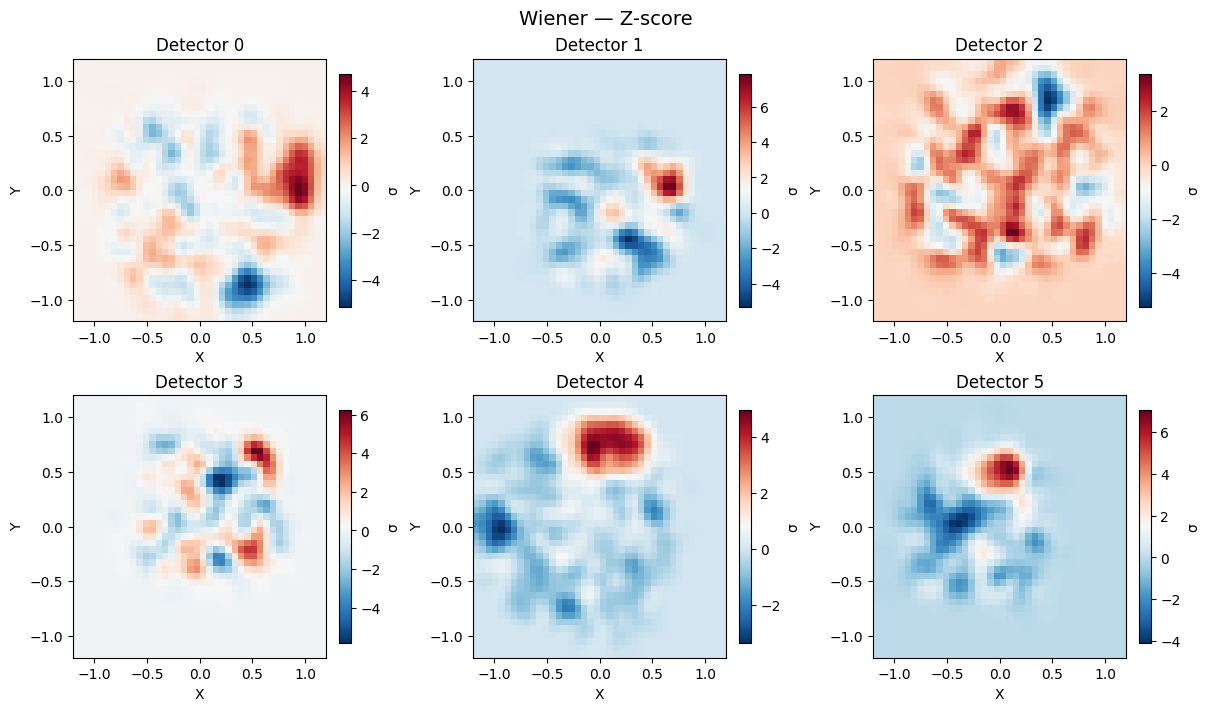

In [ ]:
# Normalizar cada variante
res_gauss_z   = add_zscore_to_results(res_gauss,   key_in="hD_gauss_rot",   key_out="hD_gauss_z")
#res_wavelet_z = add_zscore_to_results(res_wavelet, key_in="hD_wave_rot",    key_out="hD_wave_z")
res_wiener_z  = add_zscore_to_results(res_wiener,  key_in="hD_wiener_rot",  key_out="hD_wiener_z")

# Graficar 2D (3×2) con escala fija ±4σ 
plot_detectors_grid_fixed_sigma(res_gauss_z,   key="hD_gauss_z",  sigma_lim=4, suptitle="Gaussiano — Z-score")
#plot_detectors_grid_fixed_sigma(res_wavelet_z, key="hD_wave_z",   sigma_lim=4, suptitle="Wavelet — Z-score")
plot_detectors_grid_fixed_sigma(res_wiener_z,  key="hD_wiener_z", sigma_lim=4, suptitle="Wiener — Z-score")


In [ ]:
# =================== DENSIDADES (g/cm³) ===================
DENSIDADES = {
    "agua": 1.0,     # g/cm³
    "roca": 2.6,     # g/cm³
    "cobre": 8.96,   # g/cm³
}

# =================== DIFERENCIAS RELATIVAS ===================
# Se calcula automáticamente: Δρ_material = ρ_material - ρ_roca
delta_rho_agua  = DENSIDADES["agua"]  - DENSIDADES["roca"]   # -1.6
delta_rho_cobre = DENSIDADES["cobre"] - DENSIDADES["roca"]   # +6.36

# Escala relativa entre ambos (normalizada a la magnitud mayor)
ratio = abs(delta_rho_agua) / abs(delta_rho_cobre)  # ≈ 0.25

print("Δρ(agua-roca):", delta_rho_agua)
print("Δρ(cobre-roca):", delta_rho_cobre)
print("Ratio relativo (agua:cobre) =", round(ratio, 2))


Δρ(agua-roca): -1.6
Δρ(cobre-roca): 6.360000000000001
Ratio relativo (agua:cobre) = 0.25


In [ ]:
import numpy as np

def split_pos_neg_physical(res_dict, key_in="hD_wiener_z",
                           key_pos="hD_pos", key_neg="hD_neg",
                           densidades=None):
    """
    Divide cada mapa en positivos y negativos, y los escala
    a valores físicos relativos de densidad (g/cm³).

    Parámetros:
    - res_dict: resultados con mapas Z o similares
    - key_in: campo con los valores base
    - densidades: dict con {'agua': 1.0, 'roca': 2.6, 'cobre': 8.96}
      (la roca siempre se considera 0 de referencia)

    Devuelve un nuevo dict con mapas escalados:
      - key_pos -> valores entre 0 y +|Δρ_agua-roca|
      - key_neg -> valores entre 0 y -|Δρ_cobre-roca|
    """

    if densidades is None:
        densidades = {"agua": 1.0, "roca": 2.6, "cobre": 8.96}

    Δρ_agua  = densidades["agua"]  - densidades["roca"]   # negativo
    Δρ_cobre = densidades["cobre"] - densidades["roca"]   # positivo

    out = {}
    for det, r in res_dict.items():
        M = np.array(r[key_in], dtype=float)

        # separar
        M_pos = np.where(M > 0, M, 0.0)
        M_neg = np.where(M < 0, M, 0.0)

        # escalar positivos 
        if np.any(M_pos > 0):
            max_pos = np.nanmax(M_pos)
            M_pos_scaled = (M_pos / max_pos) * abs(Δρ_agua)  # rango 0 → |Δρ_agua-roca|
        else:
            M_pos_scaled = np.zeros_like(M_pos)

        # escalar negativos 
        if np.any(M_neg < 0):
            min_neg = np.nanmin(M_neg)
            M_neg_scaled = (M_neg / abs(min_neg)) * abs(Δρ_cobre)  # rango 0 → -|Δρ_cobre-roca|
        else:
            M_neg_scaled = np.zeros_like(M_neg)

        r_new = dict(r)
        r_new[key_pos] = M_pos_scaled
        r_new[key_neg] = M_neg_scaled
        out[det] = r_new

    return out

# Aplicar a Wiener
res_wiener_phys = split_pos_neg_physical(res_wiener_z,
                                         key_in="hD_wiener_z",
                                         key_pos="dens_agua",
                                         key_neg="dens_cobre",
                                         densidades=DENSIDADES)

# res_gauss_phys = split_pos_neg_physical(res_gauss_z,
#                                         key_in="hD_gauss_z",
#                                         key_pos="dens_agua",
#                                         key_neg="dens_cobre",
#                                         densidades=DENSIDADES)


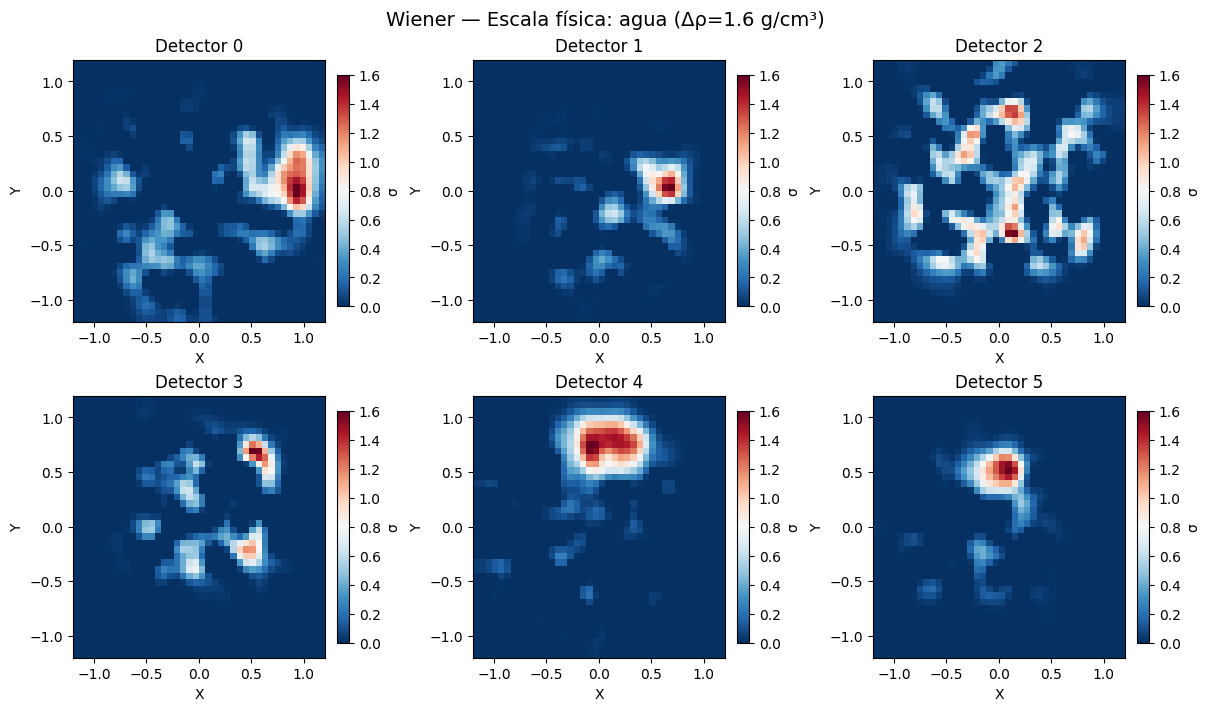

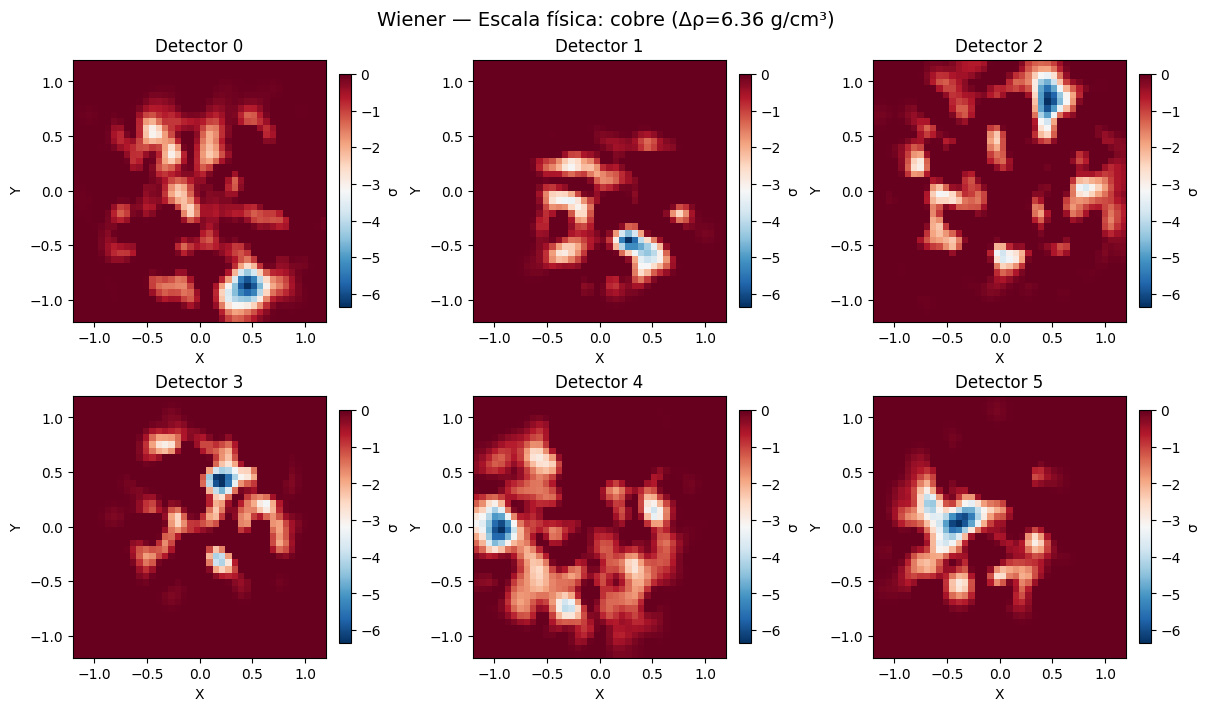

In [154]:
plot_detectors_grid_fixed_sigma(res_wiener_phys, key="dens_agua", sigma_lim=1,
                                suptitle="Wiener — Escala física: agua (Δρ=1.6 g/cm³)")
plot_detectors_grid_fixed_sigma(res_wiener_phys, key="dens_cobre", sigma_lim=6,
                                suptitle="Wiener — Escala física: cobre (Δρ=6.36 g/cm³)")


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def kmeans_on_channel_signed(res_dict,
                             key_in,
                             key_out,
                             n_clusters=2,
                             cmap="RdBu"):
    """
    Aplicar K-Means a los mapa que pueden ser todo positivo 
    o todo negativo.
    """
    out = {}
    n_det = len(res_dict)
    nrows = 2
    ncols = int(np.ceil(n_det / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    axes = axes.ravel()

    for i, (det, r) in enumerate(res_dict.items()):
        M = np.array(r[key_in], dtype=float)
        flat = M.reshape(-1)

        mean_val = np.nanmean(flat)
        if mean_val < 0:
            mask = flat < 0
            data = flat[mask].reshape(-1, 1)
            data_for_km = np.abs(data)
        else:
            mask = flat > 0
            data = flat[mask].reshape(-1, 1)
            data_for_km = data  

        if data_for_km.size == 0:
            r_new = dict(r)
            r_new[key_out] = np.zeros_like(M)
            out[det] = r_new
            continue

        km = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
        km.fit(data_for_km)

        labels_full = np.full(flat.shape, -1, dtype=int)
        labels_full[mask] = km.predict(data_for_km)
        labels_img = labels_full.reshape(M.shape)

        centers = km.cluster_centers_.flatten()
        best_cluster = np.argmax(centers)
        M_masked = np.where(labels_img == best_cluster, M, 0.0)

        r_new = dict(r)
        r_new[key_out] = M_masked
        r_new[key_out + "_labels"] = labels_img
        r_new[key_out + "_centers"] = centers
        out[det] = r_new

        ax = axes[i]
        im = ax.imshow(M_masked, origin="lower", cmap=cmap)
        ax.set_title(f"Det {det} — {key_in}")
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.suptitle(f"K-Means sobre {key_in} (auto positivo/negativo)")
    plt.tight_layout()
    plt.show()

    return out


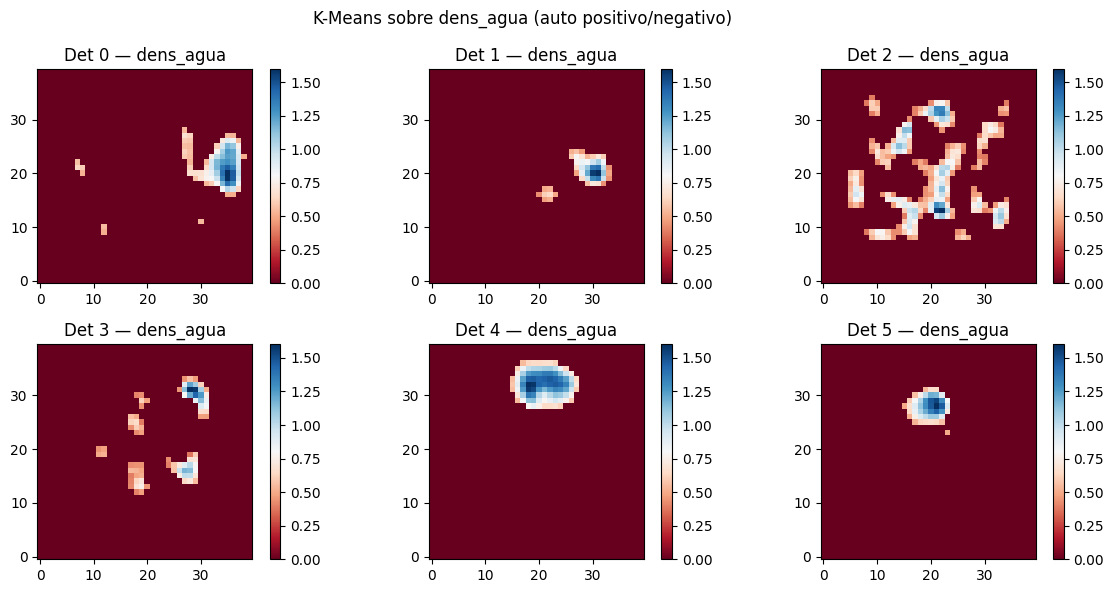

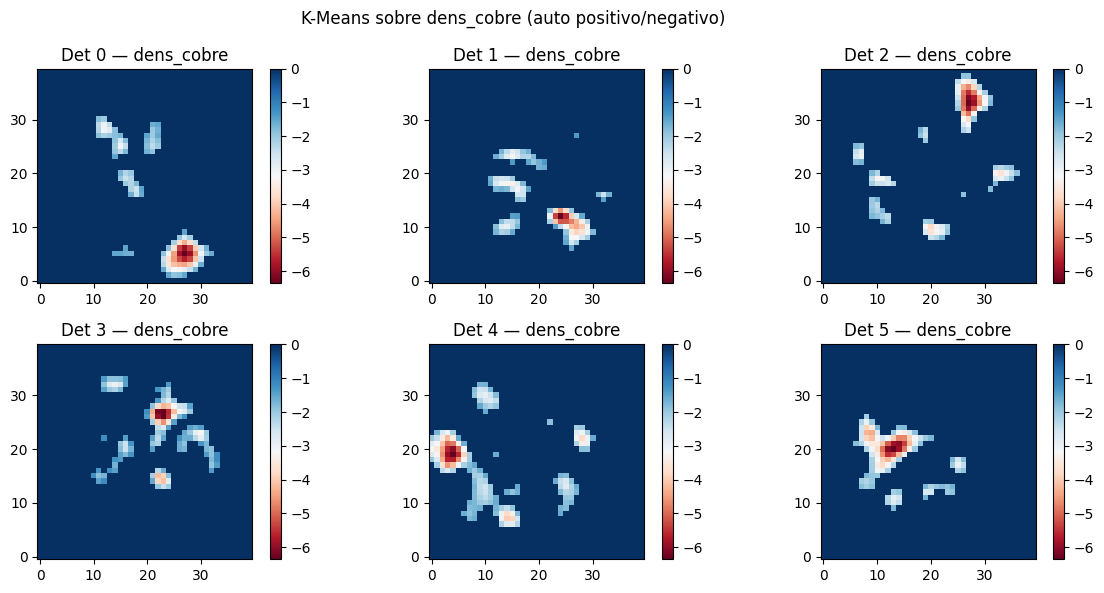

In [156]:
# agua
res_wiener_agua_km = kmeans_on_channel_signed(
    res_wiener_phys,
    key_in="dens_agua",
    key_out="dens_agua_km",
    n_clusters=2
)

# cobre
res_wiener_cobre_km = kmeans_on_channel_signed(
    res_wiener_phys,
    key_in="dens_cobre",
    key_out="dens_cobre_km",
    n_clusters=2
)


In [ ]:
import numpy as np
from scipy.ndimage import label, center_of_mass

def extract_objects_from_detector(mask_img, det_id, min_pixels=3):
    """
    mask_img: mapa 2D donde el objeto está con valor != 0
    det_id: número de detector
    min_pixels: para ignorar manchitas muy chicas
    """
    # binarizar
    bin_img = (mask_img != 0).astype(np.uint8)

    # etiquetar componentes
    labeled, ncomp = label(bin_img)
    objs = []
    for lab in range(1, ncomp+1):
        coords = np.argwhere(labeled == lab)
        if len(coords) < min_pixels:
            continue  # ruido chico

        area = len(coords)
        # centro en pixeles (fila, col)
        cy, cx = coords.mean(axis=0)

        objs.append({
            "det": det_id,
            "label": lab,
            "area": area,
            "cy": float(cy),
            "cx": float(cx),
            "mask": (labeled == lab)
        })
    return objs


In [ ]:
res_dict = res_wiener_agua_km   

total_objetos = 0
det_counts = {}

for det, r in res_dict.items():
    M = r["dens_agua_km"]       
    objs = extract_objects_from_detector(M, det_id=det, min_pixels=3)

    n = len(objs)
    det_counts[det] = n
    total_objetos += n

    print(f"Detector {det}: {n} objeto(s) detectado(s)")

print("\nTotal objetos detectados en todos los mapas:", total_objetos)


Detector 0: 2 objeto(s) detectado(s)
Detector 1: 2 objeto(s) detectado(s)
Detector 2: 9 objeto(s) detectado(s)
Detector 3: 6 objeto(s) detectado(s)
Detector 4: 1 objeto(s) detectado(s)
Detector 5: 1 objeto(s) detectado(s)

Total objetos detectados en todos los mapas: 21


In [ ]:
import numpy as np
from scipy.ndimage import label

def select_object_by_extreme(map2d, mode="max"):
    """
    Devuelve una máscara 2D con solo el objeto que contiene
    el valor máximo (mode='max') o mínimo (mode='min') del mapa.
    """
    M = np.array(map2d, dtype=float)

    if mode == "max":
        iy, ix = np.unravel_index(np.nanargmax(M), M.shape)
    else:  # mode == "min"
        iy, ix = np.unravel_index(np.nanargmin(M), M.shape)

    # binarizar todo lo que sea distinto de 0
    bin_img = (M != 0).astype(np.uint8)

    labeled, ncomp = label(bin_img)

    lab_target = labeled[iy, ix]

    if lab_target == 0:
        return np.zeros_like(M, dtype=np.uint8)

    mask_obj = (labeled == lab_target).astype(np.uint8)
    return mask_obj


In [160]:
# agua
main_agua = {}
for det, r in res_wiener_agua_km.items():
    M = r["dens_agua_km"]
    mask = select_object_by_extreme(M, mode="max")   # agua = max
    main_agua[det] = mask

# cobre
main_cobre = {}
for det, r in res_wiener_cobre_km.items():
    M = r["dens_cobre_km"]
    mask = select_object_by_extreme(M, mode="min")   # cobre = min
    main_cobre[det] = mask


In [161]:
import matplotlib.pyplot as plt

def show_main_objects_grid(results_dict, masks_dict, key_in, title, cmap="viridis"):
    """
    Dibuja la grilla de mapas originales con la máscara del objeto principal superpuesta.
    - results_dict: diccionario con los mapas originales (dens_agua_km o dens_cobre_km)
    - masks_dict: diccionario con las máscaras binarias de cada detector
    - key_in: clave del mapa dentro de results_dict
    """
    n_det = len(results_dict)
    nrows, ncols = 2, int(np.ceil(n_det / 2))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    axes = axes.ravel()

    for i, (det, r) in enumerate(results_dict.items()):
        M = np.array(r[key_in], dtype=float)
        mask = np.array(masks_dict[det], dtype=float)

        ax = axes[i]
        im = ax.imshow(M, cmap=cmap, origin="lower")
        ax.contour(mask, levels=[0.5], colors="red", linewidths=1.5)
        ax.set_title(f"Detector {det}")
        ax.axis("off")
        plt.colorbar(im, ax=ax, fraction=0.046)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


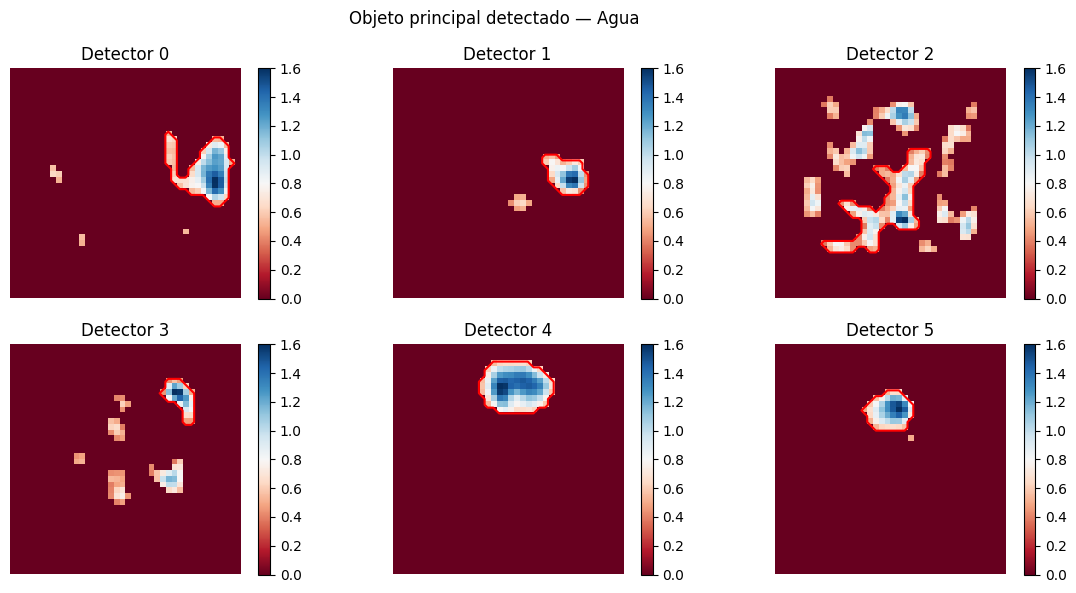

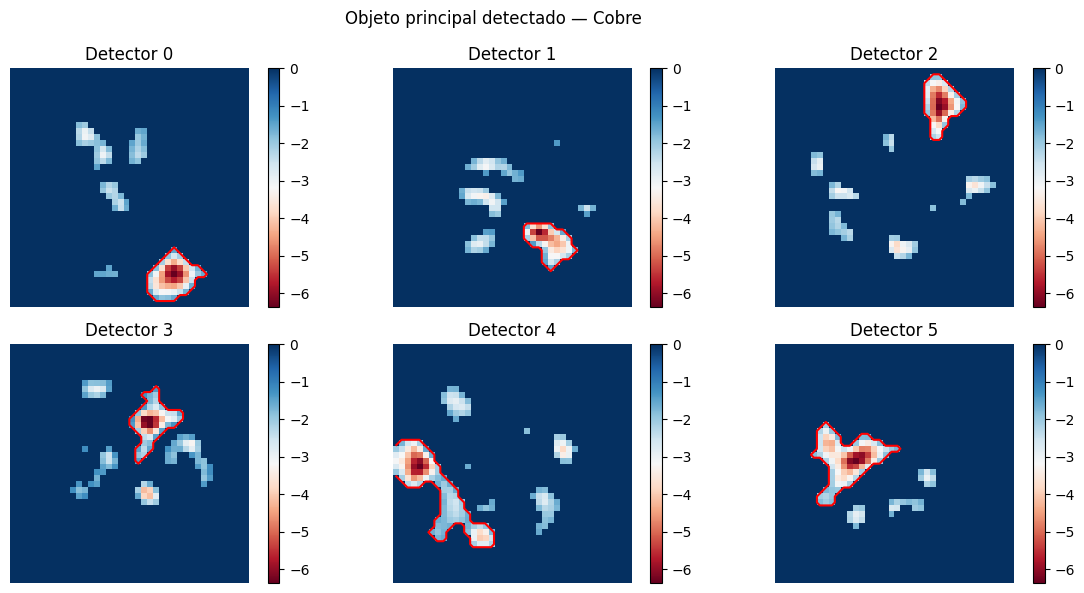

In [162]:
show_main_objects_grid(
    res_wiener_agua_km,
    main_agua,
    key_in="dens_agua_km",
    title="Objeto principal detectado — Agua",
    cmap="RdBu"
)

show_main_objects_grid(
    res_wiener_cobre_km,
    main_cobre,
    key_in="dens_cobre_km",
    title="Objeto principal detectado — Cobre",
    cmap="RdBu"
)


Probar triangulacion

In [163]:
detector_positions = [
    [-7.5,  12.99, -20.0],  # 0
    [-7.5,  12.99, -39.0],  # 1
    [-7.5, -12.99, -20.0],  # 2
    [-7.5, -12.99, -39.0],  # 3
    [ 15.,   0.00, -20.0],  # 4
    [ 15.,   0.00, -39.0],  # 5
]

In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_single_mask_3d(
    det_ids,
    detector_positions,
    base_results,       
    results_dict,        
    masks_dict,          
    key_in,             
    color="blue",
    title="Rayos",
    vol_xy_half=25.0, z_min=-40.0, z_max=0.0,
    max_rays=3000,
    flip_phi_180=True
):
    fig = go.Figure()

    for det in det_ids:
        x0, y0, z0 = detector_positions[det]

        PHI   = np.array(base_results[det]["PHI"]).ravel()
        THETA = np.array(base_results[det]["THETA"]).ravel()

        if det in results_dict and det in masks_dict:
            M = np.array(results_dict[det][key_in]).ravel()
            mask = np.array(masks_dict[det]).ravel().astype(bool)

            valid = mask & np.isfinite(PHI) & np.isfinite(THETA)
            n_valid = valid.sum()
            # print(f"{title} - Det {det}: {n_valid} rayos")
            if n_valid > 0:
                phi_v   = PHI[valid]
                theta_v = THETA[valid]

                dx = np.sin(theta_v) * np.cos(phi_v)
                dy = np.sin(theta_v) * np.sin(phi_v)
                dz = np.cos(theta_v)

                if flip_phi_180:
                    dx, dy = -dx, -dy

                if n_valid > max_rays:
                    idx = np.random.choice(n_valid, max_rays, replace=False)
                    dx, dy, dz = dx[idx], dy[idx], dz[idx]

                t = 80.0
                X1, Y1, Z1 = x0 + dx*t, y0 + dy*t, z0 + dz*t

                for xi, yi, zi, x1, y1, z1 in zip(
                    np.full_like(X1, x0),
                    np.full_like(Y1, y0),
                    np.full_like(Z1, z0),
                    X1, Y1, Z1
                ):
                    fig.add_trace(go.Scatter3d(
                        x=[xi, x1], y=[yi, y1], z=[zi, z1],
                        mode="lines",
                        line=dict(color=color, width=3),
                        opacity=0.9,
                        showlegend=False
                    ))

        
        fig.add_trace(go.Scatter3d(
            x=[x0], y=[y0], z=[z0],
            mode="markers+text",
            text=[f"Det {det}"],
            textposition="top center",
            marker=dict(size=6, color="black"),
            name=f"Det {det}"
        ))

    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[-vol_xy_half, vol_xy_half]),
            yaxis=dict(range=[-vol_xy_half, vol_xy_half]),
            zaxis=dict(range=[z_min, z_max]),
            aspectmode="data"
        ),
        title=title,
        showlegend=True
    )
    fig.show()


In [ ]:
# Positivos / agua
plot_single_mask_3d(
    det_ids=[0,1,2,3,4,5],
    detector_positions=detector_positions,
    base_results=res_wiener,              
    results_dict=res_wiener_agua_km,
    masks_dict=main_agua,
    key_in="dens_agua_km",
    color="blue",
    title="Rayos — objeto principal (AGUA / positivo)",
    vol_xy_half=25.0,
    z_min=-40.0,
    z_max=0.0,
    max_rays=3000
)

# Negativos / cobre
plot_single_mask_3d(
    det_ids=[0,1,2,3,4,5],
    detector_positions=detector_positions,
    base_results=res_wiener,
    results_dict=res_wiener_cobre_km,
    masks_dict=main_cobre,
    key_in="dens_cobre_km",
    color="red",
    title="Rayos — objeto principal (COBRE / negativo)",
    vol_xy_half=25.0,
    z_min=-40.0,
    z_max=0.0,
    max_rays=3000
)


In [ ]:
import numpy as np
import plotly.graph_objects as go


def accumulate_distinct_detectors(
    det_ids,
    detector_positions,
    base_results,
    results_dict,
    masks_dict,
    key_in,
    vol_xy_half=25.0,
    z_min=-40.0, z_max=0.0,
    voxel_size=0.9,
    ray_len=40.0,
    n_samples=90,
    flip_phi_180=True,
):
    xs = np.arange(-vol_xy_half, vol_xy_half + voxel_size, voxel_size)
    ys = np.arange(-vol_xy_half, vol_xy_half + voxel_size, voxel_size)
    zs = np.arange(z_min,         z_max + voxel_size,      voxel_size)

    nx, ny, nz = len(xs), len(ys), len(zs)
    counts = np.zeros((nx, ny, nz), dtype=np.int16)

    def world_to_idx(x, y, z):
        ix = int((x - xs[0]) / voxel_size)
        iy = int((y - ys[0]) / voxel_size)
        iz = int((z - zs[0]) / voxel_size)
        return ix, iy, iz

    for det in det_ids:
        touched = np.zeros((nx, ny, nz), dtype=bool)

        PHI   = np.array(base_results[det]["PHI"]).ravel()
        THETA = np.array(base_results[det]["THETA"]).ravel()

        if det not in results_dict or det not in masks_dict:
            continue

        mask = np.array(masks_dict[det]).ravel().astype(bool)
        valid = mask & np.isfinite(PHI) & np.isfinite(THETA)
        if not np.any(valid):
            continue

        phi_v   = PHI[valid]
        theta_v = THETA[valid]

        dx = np.sin(theta_v) * np.cos(phi_v)
        dy = np.sin(theta_v) * np.sin(phi_v)
        dz = np.cos(theta_v)

        if flip_phi_180:
            dx, dy = -dx, -dy

        x0, y0, z0 = detector_positions[det]
        ts = np.linspace(0.0, ray_len, n_samples)

        for dirx, diry, dirz in zip(dx, dy, dz):
            X = x0 + dirx * ts
            Y = y0 + diry * ts
            Z = z0 + dirz * ts
            for x, y, z in zip(X, Y, Z):
                ix, iy, iz = world_to_idx(x, y, z)
                if 0 <= ix < nx and 0 <= iy < ny and 0 <= iz < nz:
                    touched[ix, iy, iz] = True

        counts[touched] += 1

    return counts, xs, ys, zs


# SUAVIZAR solo para visualización
def smooth_volume_3x3x3(vol):
    padded = np.pad(vol, 1, mode="edge")
    out = np.zeros_like(vol, dtype=np.float32)
    for dx in (-1, 0, 1):
        for dy in (-1, 0, 1):
            for dz in (-1, 0, 1):
                out += padded[1+dx:1+dx+vol.shape[0],
                              1+dy:1+dy+vol.shape[1],
                              1+dz:1+dz+vol.shape[2]]
    out /= 27.0
    return out


def plot_respecting_rule(raw_counts, smooth_counts, xs, ys, zs,
                         min_detectors=3,
                         title="Intersección"):
    
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")

    mask = raw_counts >= min_detectors

    Xp = X[mask]
    Yp = Y[mask]
    Zp = Z[mask]
    Vp = smooth_counts[mask]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=Xp, y=Yp, z=Zp,
        mode="markers",
        marker=dict(
            size=2.4,
            color=Vp,
            colorscale="Plasma",
            opacity=0.2,
            colorbar=dict(title="(suavizado)")
        ),
        name="voxels válidos"
    ))

    if len(Vp) > 0:
        fig.add_trace(go.Isosurface(
            x=X.ravel(),
            y=Y.ravel(),
            z=Z.ravel(),
            value=smooth_counts.ravel(),
            isomin=float(np.percentile(smooth_counts[mask], 60)),  
            isomax=float(smooth_counts.max()),
            surface_count=1,
            opacity=0.45,
            colorscale="Plasma",
            caps=dict(x_show=False, y_show=False, z_show=False),
            name="núcleo"
        ))

    fig.update_layout(
        scene=dict(aspectmode="data"),
        title=title,
        showlegend=False
    )
    fig.show()


In [ ]:
counts_cobre, xs, ys, zs = accumulate_distinct_detectors(
    det_ids=[0,1,2,3,4,5],
    detector_positions=detector_positions,
    base_results=res_wiener,
    results_dict=res_wiener_cobre_km,
    masks_dict=main_cobre,
    key_in="dens_cobre_km",
    vol_xy_half=25.0,
    z_min=-40.0,
    z_max=0.0,
    voxel_size=1.5,
    ray_len=40.0,
    n_samples=90,
)

counts_cobre_smooth = smooth_volume_3x3x3(counts_cobre)

plot_respecting_rule(
    raw_counts=counts_cobre,
    smooth_counts=counts_cobre_smooth,
    xs=xs, ys=ys, zs=zs,
    min_detectors=3,   
    title="Intersección COBRE "
)


In [ ]:

counts_agua, xs_a, ys_a, zs_a = accumulate_distinct_detectors(
    det_ids=[0,1,2,3,4,5],
    detector_positions=detector_positions,
    base_results=res_wiener,           
    results_dict=res_wiener_agua_km,   
    masks_dict=main_agua,              
    key_in="dens_agua_km",
    vol_xy_half=25.0,
    z_min=-40.0,
    z_max=0.0,
    voxel_size=2.0,
    ray_len=40.0,
    n_samples=90,
)

counts_agua_smooth = smooth_volume_3x3x3(counts_agua)

plot_respecting_rule(
    raw_counts=counts_agua,
    smooth_counts=counts_agua_smooth,
    xs=xs_a, ys=ys_a, zs=zs_a,
    min_detectors=2,   
    title="Intersección AGUA "
)


In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_projections_xy_xz(counts, xs, ys, zs, title_prefix=""):
    
    proj_xy = counts.sum(axis=2)  #
    proj_xz = counts.sum(axis=1)  


    fig_xy = go.Figure(data=go.Heatmap(
        x=ys,          
        y=xs,           
        z=proj_xy,
        colorscale="Plasma",
        colorbar=dict(title="sum z")
    ))
    fig_xy.update_layout(
        title=f"{title_prefix} proyección XY (vista arriba)",
        xaxis_title="y",
        yaxis_title="x",
        yaxis=dict(scaleanchor="x", scaleratio=1)  
    )
    fig_xy.show()

    
    fig_xz = go.Figure(data=go.Heatmap(
        x=zs,           
        y=xs,           
        z=proj_xz,
        colorscale="Plasma",
        colorbar=dict(title="sum y")
    ))
    fig_xz.update_layout(
        title=f"{title_prefix} proyección XZ (vista lateral)",
        xaxis_title="z",
        yaxis_title="x",
        yaxis=dict(scaleanchor="x", scaleratio=1)
    )
    fig_xz.show()


In [ ]:

plot_projections_xy_xz(
    counts_agua,
    xs_a, ys_a, zs_a,
    title_prefix="AGUA"
)


In [171]:
plot_projections_xy_xz(
    counts_cobre,
    xs, ys, zs,
    title_prefix="COBRE"
)


In [ ]:
import numpy as np
import plotly.graph_objects as go

def gaussian_kernel_2d(size=5, sigma=1.0):
    """
    size: debe ser impar
    """
    ax = np.arange(-(size//2), size//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

def conv2d(image, kernel):
    kh, kw = kernel.shape
    ph, pw = kh//2, kw//2
    padded = np.pad(image, ((ph, ph), (pw, pw)), mode='edge')
    out = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            patch = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(patch * kernel)
    return out

def plot_final_projections_gaussian(
    raw_counts,
    smooth_counts,
    xs, ys, zs,
    min_detectors=3,
    gauss_size=5,
    gauss_sigma=1.0,
    title_prefix="",
    use_max=False,   
):
    
    mask = raw_counts >= min_detectors
    vol = np.zeros_like(smooth_counts)
    vol[mask] = smooth_counts[mask]


    if use_max:
        proj_xy = vol.max(axis=2)   
        proj_xz = vol.max(axis=1)   
    else:
        proj_xy = vol.sum(axis=2)
        proj_xz = vol.sum(axis=1)

    
    gk = gaussian_kernel_2d(size=gauss_size, sigma=gauss_sigma)
    proj_xy_s = conv2d(proj_xy, gk)
    proj_xz_s = conv2d(proj_xz, gk)

    
    fig_xy = go.Figure(data=go.Heatmap(
        x=ys,          
        y=xs,          
        z=proj_xy_s,
        colorscale="Plasma",
        colorbar=dict(title="densidad")
    ))
    fig_xy.update_layout(
        title=f"{title_prefix} — proyección XY (gauss)",
        xaxis_title="y",
        yaxis_title="x",
        yaxis=dict(scaleanchor="x", scaleratio=1)
    )
    fig_xy.show()

    
    fig_xz = go.Figure(data=go.Heatmap(
        x=zs,
        y=xs,
        z=proj_xz_s,
        colorscale="Plasma",
        colorbar=dict(title="densidad")
    ))
    fig_xz.update_layout(
        title=f"{title_prefix} — proyección XZ (gauss)",
        xaxis_title="z",
        yaxis_title="x",
        yaxis=dict(scaleanchor="x", scaleratio=1)
    )
    fig_xz.show()


In [ ]:
plot_final_projections_gaussian(
    raw_counts=counts_cobre,
    smooth_counts=counts_cobre_smooth,
    xs=xs, ys=ys, zs=zs,
    min_detectors=3,
    gauss_size=5,       
    gauss_sigma=1.0,    
    title_prefix="COBRE",
    use_max=False       
)


In [174]:
plot_final_projections_gaussian(
    raw_counts=counts_agua,
    smooth_counts=counts_agua_smooth,
    xs=xs_a, ys=ys_a, zs=zs_a,
    min_detectors=2,
    gauss_size=5,
    gauss_sigma=1.0,
    title_prefix="AGUA",
    use_max=False
)


In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter  


def make_frustum_mask(xs, ys, zs,
                      cx, cy, z_start,
                      height,
                      r_top, r_bottom,
                      direction="down"):
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")

    if direction == "down":
        z_top = z_start                 
        z_bottom = z_start - height    
        in_z = (Z <= z_top) & (Z >= z_bottom)
        t = (z_top - Z) / (height + 1e-9)
        R = r_top + t * (r_bottom - r_top)
    else:  # "up"
        z_bottom = z_start
        z_top = z_start + height
        in_z = (Z >= z_bottom) & (Z <= z_top)
        t = (Z - z_bottom) / (height + 1e-9)
        R = r_top + t * (r_bottom - r_top)

    dist = np.sqrt((X - cx)**2 + (Y - cy)**2)
    return in_z & (dist <= R)


def plot_cloud_vs_cone_with_metrics(
    raw_counts,
    smooth_counts,
    xs, ys, zs,
    min_detectors,
    cone_mask,
    cone_params,
    title=""
):
   
    detected_mask = raw_counts >= min_detectors
    inter_mask = detected_mask & cone_mask

    gt_voxels  = cone_mask.sum()
    det_voxels = detected_mask.sum()
    inter_voxels = inter_mask.sum()

    coverage = inter_voxels / gt_voxels * 100 if gt_voxels else 0
    precision = inter_voxels / det_voxels * 100 if det_voxels else 0

    print(f"{title}")
    print(f"  GT (cono):      {gt_voxels}")
    print(f"  Detectados:     {det_voxels}")
    print(f"  Intersección:   {inter_voxels}")
    print(f"  Cobertura GT:   {coverage:5.1f} %")
    print(f"  Precisión nube: {precision:5.1f} %")

    X, Y, Z = np.meshgrid(xs, ys, zs, indexing="ij")
    fig = go.Figure()

  
    fig.add_trace(go.Scatter3d(
        x=X[detected_mask],
        y=Y[detected_mask],
        z=Z[detected_mask],
        mode="markers",
        marker=dict(
            size=2.5,
            color=smooth_counts[detected_mask],  
            colorscale="Plasma",
            opacity=0.18,
        ),
        name="nube"
    ))

 
    cx = cone_params["cx"]
    cy = cone_params["cy"]
    z_start = cone_params["z_start"]
    height = cone_params["height"]
    r_top = cone_params["r_top"]
    r_bottom = cone_params["r_bottom"]
    direction = cone_params.get("direction", "down")

    cone_x, cone_y, cone_z = [], [], []
    n_theta = 50
    n_z = 30
    if direction == "down":
        for k in np.linspace(0, 1, n_z):
            z = z_start - k * height
            r = r_top + k * (r_bottom - r_top)
            thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
            cone_x.extend(cx + r * np.cos(thetas))
            cone_y.extend(cy + r * np.sin(thetas))
            cone_z.extend(np.full_like(thetas, z, dtype=float))
    else:  # up
        for k in np.linspace(0, 1, n_z):
            z = z_start + k * height
            r = r_top + k * (r_bottom - r_top)
            thetas = np.linspace(0, 2*np.pi, n_theta, endpoint=False)
            cone_x.extend(cx + r * np.cos(thetas))
            cone_y.extend(cy + r * np.sin(thetas))
            cone_z.extend(np.full_like(thetas, z, dtype=float))

    fig.add_trace(go.Scatter3d(
        x=cone_x, y=cone_y, z=cone_z,
        mode="markers",
        marker=dict(size=2, color="cyan", opacity=0.25),
        name="cono real"
    ))

   
    if smooth_counts.max() > 0:
        fig.add_trace(go.Isosurface(
            x=X.ravel(),
            y=Y.ravel(),
            z=Z.ravel(),
            value=smooth_counts.ravel(),
            isomin=float(np.percentile(smooth_counts, 70)),  
            isomax=float(smooth_counts.max()),
            surface_count=1,
            opacity=0.4,
            colorscale="Plasma",
            caps=dict(x_show=False, y_show=False, z_show=False),
            name="núcleo (gauss)"
        ))

    fig.update_layout(
        scene=dict(aspectmode="data"),
        title=f"{title}<br>Cobertura={coverage:4.1f}% | Precisión={precision:4.1f}%",
    )
    fig.show()




In [ ]:
cone_params_cu = dict(
    cx=0.0,
    cy=0.0,
    z_start=-5.0,   
    height=5.0,     
    r_top=1.0,     
    r_bottom=5.0,  
    direction="down"
)

cone_mask_cu = make_frustum_mask(
    xs, ys, zs,
    cx=cone_params_cu["cx"],
    cy=cone_params_cu["cy"],
    z_start=cone_params_cu["z_start"],
    height=cone_params_cu["height"],
    r_top=cone_params_cu["r_top"],
    r_bottom=cone_params_cu["r_bottom"],
    direction=cone_params_cu["direction"],
)

plot_cloud_vs_cone_with_metrics(
    raw_counts=counts_cobre,              
    smooth_counts=counts_cobre_smooth,    
    xs=xs, ys=ys, zs=zs,
    min_detectors=3,
    cone_mask=cone_mask_cu,
    cone_params=cone_params_cu,
    title="COBRE "
)


COBRE 
  GT (cono):      66
  Detectados:     610
  Intersección:   64
  Cobertura GT:    97.0 %
  Precisión nube:  10.5 %


In [ ]:
from scipy.ndimage import gaussian_filter


counts_agua_smooth = gaussian_filter(counts_agua.astype(float), sigma=1.2)

cone_params_agua = dict(
    cx=17.0,
    cy=17.0,
    z_start=-10.0,   
    height=10.0,     
    r_top=1.0,      
    r_bottom=5.0,   
    direction="up"   
)

cone_mask_agua = make_frustum_mask(
    xs_a, ys_a, zs_a,
    cx=cone_params_agua["cx"],
    cy=cone_params_agua["cy"],
    z_start=cone_params_agua["z_start"],
    height=cone_params_agua["height"],
    r_top=cone_params_agua["r_top"],
    r_bottom=cone_params_agua["r_bottom"],
    direction=cone_params_agua["direction"],
)


plot_cloud_vs_cone_with_metrics(
    raw_counts=counts_agua,              
    smooth_counts=counts_agua_smooth,    
    xs=xs_a, ys=ys_a, zs=zs_a,
    min_detectors=2,                     
    cone_mask=cone_mask_agua,
    cone_params=cone_params_agua,
    title="AGUA"
)


AGUA
  GT (cono):      50
  Detectados:     593
  Intersección:   46
  Cobertura GT:    92.0 %
  Precisión nube:   7.8 %
